In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import coremltools as ct  # Ensure coremltools is installed


TensorFlow version 2.13.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


In [2]:
# Directory
train_data_dir = '/Users/rishabhsolanki/Desktop/Machine learning/ios/Data/train_data'

# Image dimensions
img_width, img_height = 150, 150
batch_size = 5


In [3]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

# Training and Validation Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 58 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


In [4]:
# Model Definition
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [5]:
# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [6]:
# Train Model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/5
11/11 [==============================] - 2s 118ms/step - loss: 0.8542 - accuracy: 0.4906 - val_loss: 0.6777 - val_accuracy: 0.6000
Epoch 2/5
11/11 [==============================] - 1s 92ms/step - loss: 0.7168 - accuracy: 0.5660 - val_loss: 0.7087 - val_accuracy: 0.5000
Epoch 3/5
11/11 [==============================] - 1s 102ms/step - loss: 0.6888 - accuracy: 0.5094 - val_loss: 0.6957 - val_accuracy: 0.4000
Epoch 4/5
11/11 [==============================] - 1s 102ms/step - loss: 0.6853 - accuracy: 0.5849 - val_loss: 0.6876 - val_accuracy: 0.6000
Epoch 5/5
11/11 [==============================] - 1s 105ms/step - loss: 0.6831 - accuracy: 0.5472 - val_loss: 0.6644 - val_accuracy: 0.6000


In [7]:
# Feature Extraction with CNN
# A new model is being created here
feature_model = Model(inputs=model.input, outputs=model.layers[-5].output)  # Extracting features before Flatten layer
train_features = feature_model.predict(train_generator)
val_features = feature_model.predict(val_generator)

3/3 [==============================] - 0s 63ms/step


In [8]:
# RandomForest Training
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_features, train_generator.classes)

RandomForestClassifier()

In [9]:
# Predictions
val_images, val_labels = next(val_generator)
cnn_predictions = model.predict(val_images)
val_features = feature_model.predict(val_images)
rf_predictions = clf.predict(val_features)

1/1 [==============================] - 0s 48ms/step


In [10]:
# Combine Predictions
final_predictions = 0.5 * cnn_predictions.flatten() + 0.5 * rf_predictions
final_class_predictions = [1 if pred > 0.5 else 0 for pred in final_predictions]

In [11]:
# Display Results
print("True Labels:", val_labels)
print("CNN Predictions:", cnn_predictions.flatten())
print("RandomForest Predictions:", rf_predictions)
print("Combined Predictions:", final_class_predictions)

True Labels: [0. 1. 1. 1. 1.]
CNN Predictions: [0.4490894  0.4539325  0.45100594 0.4688384  0.44377533]
RandomForest Predictions: [1 1 0 0 0]
Combined Predictions: [1, 1, 0, 0, 0]


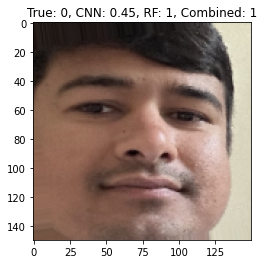

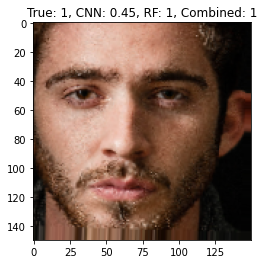

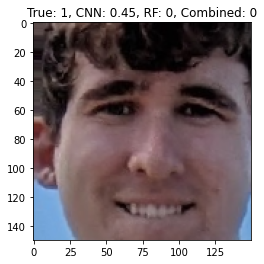

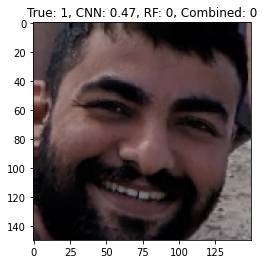

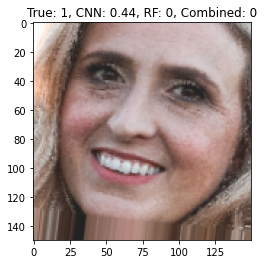

In [12]:
# Visualize the results
for i in range(len(val_images)):
    plt.imshow(val_images[i])
    plt.title(f"True: {int(val_labels[i])}, CNN: {cnn_predictions[i][0]:.2f}, RF: {rf_predictions[i]}, Combined: {final_class_predictions[i]}")
    plt.show()


In [13]:
import coremltools
from coremltools.models.neural_network import NeuralNetworkBuilder, SgdParams

In [14]:
# Save the Keras model first
keras_model_path = './model.h5'
model.save(keras_model_path)

/opt/homebrew/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# If the model expects 3 channels, adjust the input shape and preprocessing details
input_shape = (1, 150, 150, 3)
input_shape_spec = ct.Shape(shape=input_shape)
input_spec = ct.ImageType(shape=input_shape_spec, bias=[0, 0, 0], scale=1/255.0)
input_spec.name = "conv2d_input"

In [16]:
# Convert the Keras model to CoreML model with specified input details
coreml_model_path = './MyModel.mlmodel'
coreml_model = ct.convert(model, inputs=[input_spec], source="tensorflow")
coreml_model.save(coreml_model_path)
print("CoreML Model saved!")

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 61/61 [00:01<00:00, 40.80 ops/s]


CoreML Model saved!


In [17]:
def make_updatable(mlmodel_url, mlmodel_updatable_path):
    # Load the model
    spec = ct.utils.load_spec(mlmodel_url)
    builder = ct.models.neural_network.NeuralNetworkBuilder(spec=spec)

    # Inspect the last few layers
    print(builder.inspect_layers(last=5))

    # Make the last two dense layers updatable
    builder.make_updatable(['sequential/dense_2/BiasAdd', 'sequential/dense_1/BiasAdd'])  # Adjust names if they differ in your model

    # Retrieve name of the output of the last layer
    last_layer_output = builder.spec.neuralNetwork.layers[-1].output[0]

    # Add the softmax layer
    builder.add_softmax(name='SoftmaxLayer', input_name=last_layer_output, output_name='output1')

    # Set the loss and optimizer
    builder.set_categorical_cross_entropy_loss(name='lossLayer', input='output1')  # 'output1' is the output of the softmax layer
    builder.set_sgd_optimizer(SgdParams(lr=0.01, batch=1))
    builder.set_epochs(5)

    # Set training input descriptions
    spec.description.trainingInput[0].shortDescription = 'Input image for training'
    spec.description.trainingInput[1].shortDescription = 'True label for the input image'
    
    # Save the updated model
    updatable_model = ct.models.MLModel(spec)
    updatable_model.save(mlmodel_updatable_path)

In [18]:
coreml_updatable_model_path = './UpdatableModel.mlmodel'
make_updatable(coreml_model_path, coreml_updatable_model_path)

[Id: 16], Name: sequential/activation_5/Sigmoid (Type: activation)
          Updatable: False
          Input blobs: ['sequential/dense_2/BiasAdd']
          Output blobs: ['Identity']
[Id: 15], Name: sequential/dense_2/BiasAdd (Type: innerProduct)
          Updatable: False
          Input blobs: ['sequential/activation_4/Relu']
          Output blobs: ['sequential/dense_2/BiasAdd']
[Id: 14], Name: sequential/activation_4/Relu (Type: activation)
          Updatable: False
          Input blobs: ['sequential/dense_1/BiasAdd']
          Output blobs: ['sequential/activation_4/Relu']
[Id: 13], Name: sequential/dense_1/BiasAdd (Type: innerProduct)
          Updatable: False
          Input blobs: ['sequential/activation_3/Relu']
          Output blobs: ['sequential/dense_1/BiasAdd']
[Id: 12], Name: sequential/activation_3/Relu (Type: activation)
          Updatable: False
          Input blobs: ['sequential/dense/BiasAdd']
          Output blobs: ['sequential/activation_3/Relu']
None
Now 

In [19]:
# Verify the model's updatable layers, loss, and optimizer
builder = coremltools.models.neural_network.NeuralNetworkBuilder(spec=coremltools.utils.load_spec(coreml_updatable_model_path))
builder.inspect_loss_layers()
builder.inspect_optimizer()
# let's see which layers are updatable
builder.inspect_updatable_layers()


[Id: 0], Name: lossLayer (Type: categoricalCrossEntropyLossLayer)
          Loss Input: output1
          Loss Target: output1_true
Optimizer Type: sgdOptimizer
lr: 0.01, min: 0.0, max: 1.0
batch: 1, allowed_set: [1]
momentum: 0.0, min: 0.0, max: 1.0
Name: sequential/dense_2/BiasAdd (Type: innerProduct)
          Input blobs: ['sequential/activation_4/Relu']
          Output blobs: ['sequential/dense_2/BiasAdd']
Name: sequential/dense_1/BiasAdd (Type: innerProduct)
          Input blobs: ['sequential/activation_3/Relu']
          Output blobs: ['sequential/dense_1/BiasAdd']
